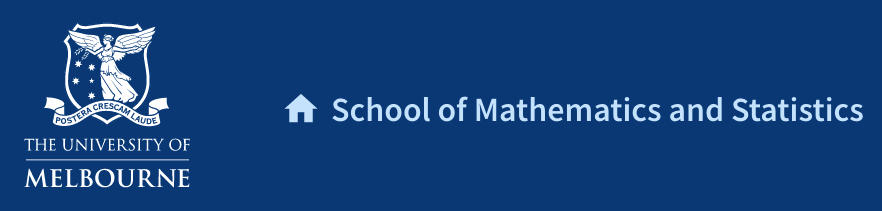

# MAST 90098 - Approximation Algorithms and Heuristics

Solutions developed by Cameroon Chandler (2022 student)

## Tutorial - Week 4

The QAP arises in many applications such as facility location, data analysis, VLSI design, image synthesis, and so on. The problem can be defined as follows. Given a set of $n$ objects $O=\left\{O_{1}, O_{2}, \ldots, O_{n}\right\}$, a set of $n$ locations $L=\left\{L_{1}, L_{2}, \ldots, L_{n}\right\}$, a flow matrix $C$, where each element $c_{i j}$ denotes a flow cost between the objects $O_{i}$ and $O_{j}$, a distance matrix $D$, where each element $d_{k l}$ denotes a distance between location $L_{k}$ and $L_{l}$, find an object-location mapping $m: O \rightarrow L$ that minimizes the objective function $f:$
$$
f=\sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} \cdot d_{M(i) M(j)}
$$

Implement a function that computes the cost of a solution and returns its value. The encoding of a solution is based on a permutation of $n$ integers $s=\left(l_{1}, l_{2}, \ldots, L_{n}\right)$ where $l_{i}$ denotes the location of the object $O_{i}$. The function is tested for a small example.

In [17]:
import numpy as np

#Some simple DATA
C = [[0, 3, 2],
     [1, 0, 3],
     [4, 6, 0]]

D = [[0, 2, 3],
     [2, 0, 4],
     [5, 1, 0]]

flow = np.array(C)
dist = np.array(D)

#A function that given a solution (represented as a permutation)
#returns the QAP objective function
def cost(perm, flow, dist):
    c = 0
    
    for o1, l1 in enumerate(perm):
        for o2, l2 in enumerate(perm):
            c += flow[o1, o2] * dist[l1, l2]
    
    return c

print(cost([0,1,2], flow, dist))

52


The following code reads instances from the QAPLib, a set of instances for the QAP.

https://coral.ise.lehigh.edu/data-sets/qaplib/

In [18]:
import random
import math
import sys

def read_integers(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

file_it = iter(read_integers('QAPInstances/tai30b.dat'))

# Number of points
n = next(file_it)

# Distance between locations
C = [[next(file_it) for j in range(n)] for i in range(n)]
# Flow between factories
D = [[next(file_it) for j in range(n)] for i in range(n)]
flow = np.array(C)
dist = np.array(D)

For the instance above (tai30b.dat), the best known solution is 

perm = [3, 7, 10, 14, 16, 19, 20, 4, 13, 29, 1, 12, 5, 28, 9, 25, 26, 23, 27, 21, 11, 8, 6, 22, 18, 17, 24, 15, 0, 2]


Use your function to compute its cost and check that it is working properly (the cost should be 637117113).

Compare the cost of this solution with that of a random permutation.

In [19]:
perm = [3, 7, 10, 14, 16, 19, 20, 4, 13, 29, 1, 12, 5, 28, 9, 25, 26, 23, 27, 21, 11, 8, 6, 22, 18, 17, 24, 15, 0, 2]
cost(perm, flow, dist)

637117113

Using your cost function, implement a simulated annealing algorithm. The core of the algorithms is already described below, and receives the flow and distance datas (C and D) as specified above, an initial solution, an initial temperature, a final temperature and the number of runs at each temperature.

In [20]:
import numpy
import random
import math
import sys
from tqdm import trange

#Initial solution
perm = list(range(len(C)))

def get_neighbour(perm):
    ''' 50% chance of swap, 50% chance of insert '''
    new_perm = perm[:]
    # Two random indexes
    i = random.randint(0, len(perm)-1)
    j = random.randint(0, len(perm)-1)
    
    if random.choice([0, 1]):
        # Swap
        new_perm[i], new_perm[j] = new_perm[j], new_perm[i]
        
    else:
        # Insertion
        new_perm.insert(j, new_perm.pop(i))
        
    return new_perm
        

def SimulatedAnnealing(flow, dist, perm, T0, Tmin, nbIter, rate=0.99):
    curr_cost = cost(perm, flow, dist)
    best_cost = curr_cost
    T = T0
    perm_history = [perm]
    cost_history = [curr_cost]
    best_cost_history = [best_cost]

    while T > Tmin:
        it = 0
        while(it < nbIter):
            new_perm = get_neighbour(perm)
            new_cost = cost(new_perm, flow, dist)
            
            ΔE = new_cost - curr_cost
            if (ΔE <= 0) or (np.exp( -ΔE/T ) >= np.random.uniform()):
                perm = new_perm
                curr_cost = new_cost
                
                if curr_cost < best_cost:
                    best_cost = curr_cost
                    best_perm = perm
                    
            it += 1
            
            perm_history.append(perm)
            cost_history.append(curr_cost)
            best_cost_history.append(best_cost)
    
        T *= rate
        
    return best_perm, best_cost, perm_history, cost_history, best_cost_history

# Here is where I've added in the scipy dual annealing function

It seems to be quite a bit more advanced than vanilla simulated annealing, and it performs quite well too!

It only works with continuous variables though, so I came up with a quick encoding scheme below to turn R^n into a permutation vector. I only include it here so that you can see an example in case it was of interest.

Note that I've written a callback function just for the sake of stopping the process after a fixed length of time. A better method would just be to use the `maxiter` argument.

Find a high level description here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html

In [21]:
%%time
import numpy as np
from scipy.optimize import dual_annealing
from datetime import datetime
(datetime.now() - datetime.now()).seconds

def real2perm(array):
    ''' Converts an array in R^n into a permutation based on the sorted order of elements 
    [1.1, 7.5, 0.2, -4.2] will become [3, 2, 0, 1] (as index 3 has the smallest element and index 1 the largest)
    '''
    return np.argsort(array)

MAX_RUN_TIME = 10#seconds
start_time = datetime.now()

# Annealing stops when callback function returns True
stop = lambda x, f, context: (datetime.now() - start_time).seconds > MAX_RUN_TIME

objective_function = lambda x: cost(real2perm(x), flow, dist)
bounds = [(0, 1)] * len(flow)

ret = dual_annealing(objective_function, bounds=bounds, callback=stop)

CPU times: user 23.4 s, sys: 79.5 ms, total: 23.4 s
Wall time: 23.5 s


In [22]:
print(real2perm(ret.x))
print(ret.fun)

[ 5 18 29 10  8 25 14 27  4  3 22  9  6 23 26 19 20 16 28  0 21 17 15 13
 24  7 12  1 11  2]
836997414


Run your code for different instances and different parameters. Plot the evolution of the solutions obtained over the iterations.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# This is just for making prettier plots
SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

In [25]:
%%time
# Run the simulated annealing
init = list(range(len(C)))
best_perm, best_cost, perm_history, cost_history, best_cost_history = SimulatedAnnealing(
    flow, dist, init, T0=100_000_000, Tmin=100, nbIter=10, rate=0.99
)

CPU times: user 4.87 s, sys: 41.2 ms, total: 4.91 s
Wall time: 4.96 s


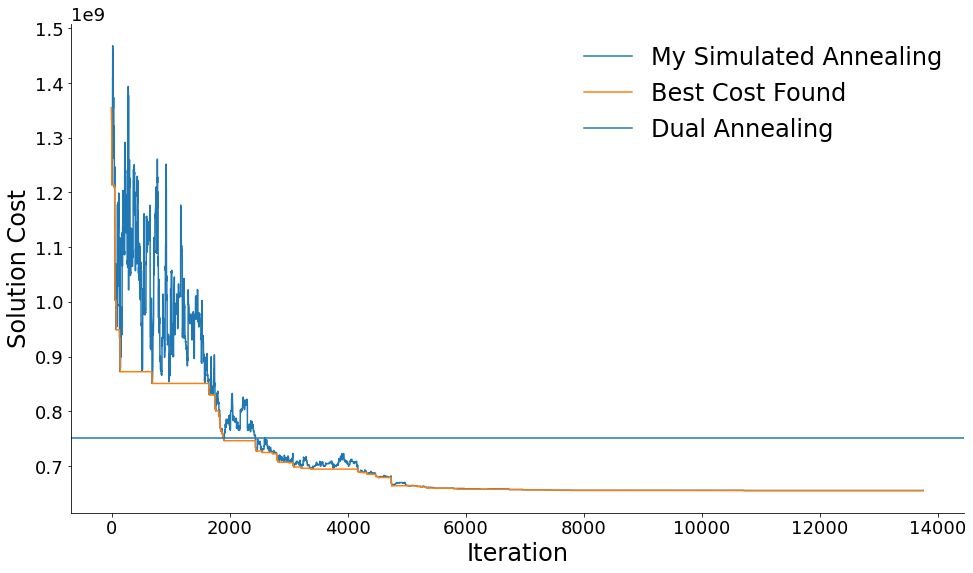

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(cost_history, label='My Simulated Annealing')
ax.plot(best_cost_history, label='Best Cost Found')
ax.axhline(ret.fun, label='Dual Annealing')

ax.set_xlabel('Iteration')
ax.set_ylabel('Solution Cost')

ax.legend(frameon=False)
sns.despine()
plt.show()

In [26]:
bests = []
alls = []

for _ in trange(5):
    init = list(range(len(C)))
    best_perm, best_cost, perm_history, cost_history, best_cost_history = SimulatedAnnealing(
        flow, dist, init, T0=100_000_000, Tmin=1000, nbIter=10, rate=0.99
    )
    
    bests.append(best_cost_history)
    alls.append(cost_history)

100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]


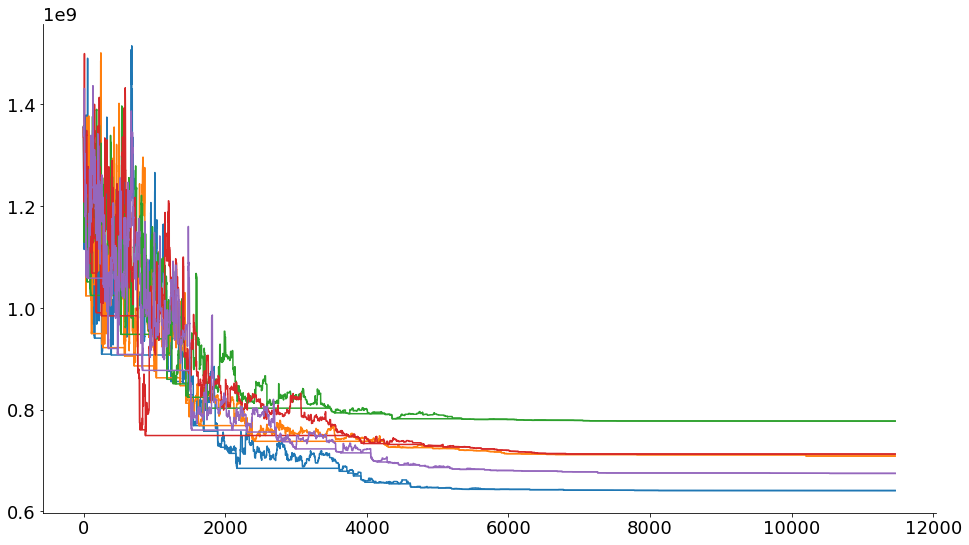

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))


for i, (best, all_) in enumerate(zip(bests, alls)):
    ax.plot(all_, color=f'C{i}')
    ax.plot(best, color=f'C{i}')

sns.despine()
plt.show()

Incremental objective function evaluation for the QAP: The incremental evaluation of the objective function in single-solution based algorithms is a very important issue to reduce the complexity of the evaluation of the neighborhood.

Define an incremental function for the previous encoding and a move operator. The move operator is based on the exchange operator where two elements of the permutation are exchanged. Your function should receive the current permutation, the current cost and the position of the locations to be exchanged and return the new permutation and new cost.

In [12]:
#ANSWER
def costIncremental(per,currentCost,i,j):
   
    return newCost, newPermutation
        

Modify your Simulated Annealing to use the incremental objective function evaluation. How much faster is your code?

In [13]:
def SimulatedAnnealingIncr(C,D,perm,T0,Tmin,nbIter):


IndentationError: expected an indented block (4228919505.py, line 1)